In [1]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, Dropout, BatchNormalization, Dense
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# extract the data out
train_data = pd.read_csv('propaganda_train.tsv', sep='\t')
test_data = pd.read_csv('propaganda_val.tsv', sep='\t')

# load datasets seperately
x_train = train_data['tagged_in_context']   
y_train = train_data['label']   
x_validation = test_data['tagged_in_context'] 
y_validation = test_data['label']

# mapping labels
propaganda_label = {
                    "flag_waving": 0,
                    "appeal_to_fear_prejudice": 1,
                    "causal_oversimplification": 2,
                    "doubt": 3,
                    "exaggeration,minimisation": 4,
                    "loaded_language": 5,
                    "name_calling,labeling": 6,
                    "repetition": 7,
                    "not_propaganda": 8
                    }
y_train = y_train.map(propaganda_label)
y_validation = y_validation.map(propaganda_label)

# tokenization
max_words = 5000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_validation = tokenizer.texts_to_sequences(x_validation)

# padding
max_len = 1000 
x_train = pad_sequences(x_train, maxlen=max_len)
x_validation = pad_sequences(x_validation, maxlen=max_len)

In [2]:
# build CNN model
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))    
model.add(Conv1D(64, 3, padding='same'))
model.add(MaxPooling1D(pool_size=3))     
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(9, activation='softmax'))

# compile & train
optm = optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_validation, y_validation))

# evaluate
result = model.evaluate(x_validation, y_validation, verbose=0)
print('Validation loss:', result[0])
print('Validation accuracy:', result[1])

Epoch 1/30
76/76 [==============================] - 7s 90ms/step - loss: 1.9013 - accuracy: 0.4374 - val_loss: 1.6851 - val_accuracy: 0.5190
Epoch 2/30
76/76 [==============================] - 7s 87ms/step - loss: 1.3784 - accuracy: 0.5634 - val_loss: 1.6010 - val_accuracy: 0.5190
Epoch 3/30
76/76 [==============================] - 6s 85ms/step - loss: 0.8164 - accuracy: 0.7506 - val_loss: 1.5367 - val_accuracy: 0.5207
Epoch 4/30
76/76 [==============================] - 7s 92ms/step - loss: 0.4464 - accuracy: 0.8811 - val_loss: 1.5986 - val_accuracy: 0.5362
Epoch 5/30
76/76 [==============================] - 7s 95ms/step - loss: 0.2631 - accuracy: 0.9350 - val_loss: 1.5153 - val_accuracy: 0.5707
Epoch 6/30
76/76 [==============================] - 7s 96ms/step - loss: 0.1747 - accuracy: 0.9602 - val_loss: 1.6020 - val_accuracy: 0.5569
Epoch 7/30
76/76 [==============================] - 7s 95ms/step - loss: 0.1463 - accuracy: 0.9673 - val_loss: 1.6641 - val_accuracy: 0.5397
Epoch 8/30
76

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 249, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 249, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 5312)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5312)              0

In [4]:
# extract the accuracies
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

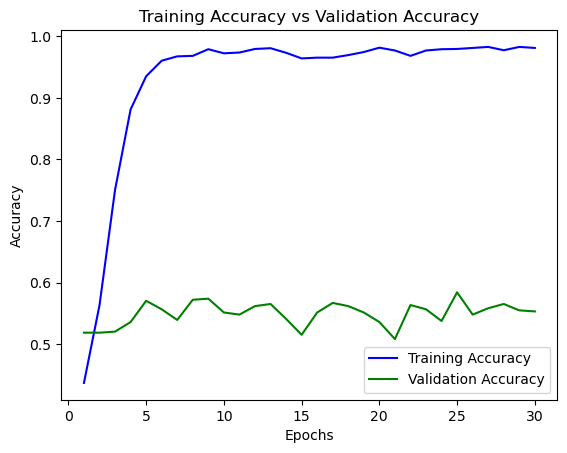

In [5]:
# Training Accuracy vs Validation Accuracy
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'blue', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'green', label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

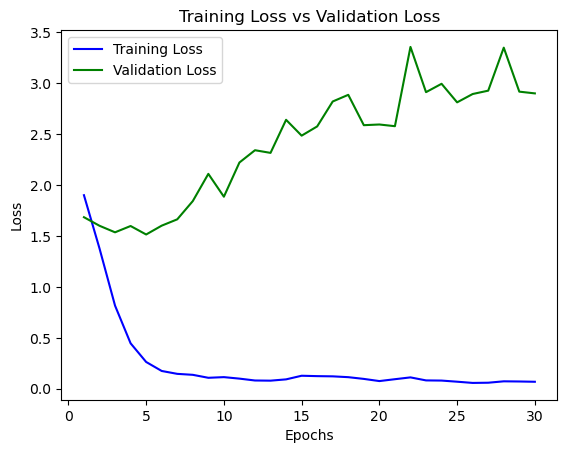

In [6]:
# Training Loss vs Validation Loss
plt.plot(epochs, train_loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'green', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
raw_prediction = model.predict(x_validation)
pred = []

for row in raw_prediction:
    highest = row[0]
    pred_idx = 0
    for idx, likelihood in enumerate(row):
        if likelihood > highest:
            highest = likelihood
            pred_idx = idx
    pred.append(pred_idx)

In [8]:
c_matrix = confusion_matrix(y_validation, pred)
p_labels = ["flag_waving",
            "appeal_to_fear_prejudice",
            "causal_oversimplification",
            "doubt",
            "exaggeration,minimisation",
            "loaded_language",
            "name_calling,labeling",
            "repetition",
            "not_propaganda"]
p_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8]
for k in propaganda_label:
    print(propaganda_label[k], ": ", k)

df = pd.DataFrame(data=c_matrix, index=p_idx, columns=p_idx)
df

0 :  flag_waving
1 :  appeal_to_fear_prejudice
2 :  causal_oversimplification
3 :  doubt
4 :  exaggeration,minimisation
5 :  loaded_language
6 :  name_calling,labeling
7 :  repetition
8 :  not_propaganda


,0,1,2,3,4,5,6,7,8
0,12,2,8,3,3,2,3,2,4
1,0,8,6,9,1,3,3,4,9
2,1,2,11,7,1,0,3,0,6
3,0,1,6,13,5,4,2,0,7
4,0,0,2,1,6,1,3,2,13
5,1,2,3,1,2,7,2,3,16
6,0,1,0,6,2,4,9,0,9
7,1,1,2,0,1,3,3,11,10
8,3,5,4,5,6,18,11,5,244


In [9]:
print(classification_report(y_validation, pred, target_names=p_labels))

                           precision    recall  f1-score   support

              flag_waving       0.67      0.31      0.42        39
 appeal_to_fear_prejudice       0.36      0.19      0.25        43
causal_oversimplification       0.26      0.35      0.30        31
                    doubt       0.29      0.34      0.31        38
exaggeration,minimisation       0.22      0.21      0.22        28
          loaded_language       0.17      0.19      0.18        37
    name_calling,labeling       0.23      0.29      0.26        31
               repetition       0.41      0.34      0.37        32
           not_propaganda       0.77      0.81      0.79       301

                 accuracy                           0.55       580
                macro avg       0.38      0.34      0.34       580
             weighted avg       0.56      0.55      0.55       580

